# Traffic Prediction 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import tensorflow as tf

2024-07-09 15:39:01.579454: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-09 15:39:01.586828: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-09 15:39:01.700182: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-09 15:39:01.702252: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-09 15:39:02.554780: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Import data

Data from https://mostwiedzy.pl/en/open-research-data/permanent-traffic-counting-stations-expressway-s6-in-gdansk-dataset-containing-5-min-aggregated-traf,923120743943369-0

The dataset comprises traffic data from a permanent traffic count station on expressway S6 in Poland's Tri-City Agglomeration area. It covers three years (2014-2017) and focuses on southbound traffic.

Data is aggregated into 5-minute intervals and includes weather and daytime information.
For each interval, details like year, month, day, hour, day of the week, season, weather conditions, and traffic volume are provided. This dataset supports the RID2B research project, funded by Poland's National Centre for Research and Development and the General Directorate for National Roads and Motorways.

The dataset is in Excel format and has been imported into a DataFrame for analysis.

In [2]:
df = pd.read_excel('Expressway_S6_Gdansk_5min.xlsx', sheet_name='data_5min_int')

In [3]:
df.head()

,interval,day of week,type of day,season,daytime,rain_intensity,rain_state,road_surface,temperature,visibility,...,gap_front_l2,gap_front_l2_pc,gap_front_l2_hv,gap_behind,gap_behind_l1,gap_behind_l1_pc,gap_behind_l1_hv,gap_behind_l2,gap_behind_l2_pc,gap_behind_l2_hv
0,2014-03-01 00:00:00,Sat,0,Spring,night,12.1,0.0,2.0,3.7,5.0,...,49.0,49.0,NaN,77,18.0,18.0,NaN,300.0,300.0,NaN
1,2014-03-01 00:05:00,Sat,0,Spring,night,12.1,0.0,2.0,3.7,5.0,...,NaN,NaN,NaN,21,21.0,20.0,32.0,NaN,NaN,NaN
2,2014-03-01 00:10:00,Sat,0,Spring,night,13.6,0.0,2.0,3.6,5.0,...,NaN,NaN,NaN,38,38.0,38.0,NaN,NaN,NaN,NaN
3,2014-03-01 00:16:00,Sat,0,Spring,night,13.6,0.0,2.0,3.6,5.0,...,NaN,NaN,NaN,37,37.0,37.0,NaN,NaN,NaN,NaN
4,2014-03-01 00:21:00,Sat,0,Spring,night,12.5,0.0,2.0,3.5,5.0,...,535.0,535.0,NaN,58,36.0,40.0,24.0,156.0,156.0,NaN


## Clean dataset

Here is a summary of the data cleaning steps I’ve performed:
- Dropping useless columns related to traffic data.
- Dropping rows with undefined values in specific columns: 'rain_intensity', 'rain_state', 'road_surface', 'temperature', 'visibility', 'avg_FFS'.
- Calculating the interval between consecutive rows in minutes as the data is no longer aggregated at 5-minute intervals.
- Identifying outliers for 'gap_front' and 'gap_behind' columns using the interquartile range (IQR) method and deciding to keep them despite representing 10% of the data

In [4]:
# drop useless columns
df.drop(['avg_speed_pc', 
         'avg_speed_hv', 
         'avg_speed_l1',
         'avg_speed_l2',
         'avg_speed_pc_l1',
         'avg_speed_pc_l2',
         'avg_speed_hv_l1',
         'avg_speed_hv_l2',
         'volume_pc',
         'volume_pc_FFS',
         'volume_hv',
         'volume_l1',
         'volume_l2',
         'volume_pc_l1',
         'volume_pc_l2',
         'volume_hv_l1',
         'volume_hv_l2',
         'stdev_speed_pc',
         'stdev_speed_hv',
         'stdev_speed_pc_l1',
         'stdev_speed_pc_l2',
         'gap_behind_l1',
         'gap_behind_l1_pc',
         'gap_behind_l1_hv',
         'gap_behind_l2',
         'gap_behind_l2_pc',
         'gap_behind_l2_hv',
         'gap_front_l1',
         'gap_front_l1_pc',
         'gap_front_l1_hv',
         'gap_front_l2',
         'gap_front_l2_pc',
         'gap_front_l2_hv',
         'avg_FFS_l1',
         'avg_FFS_l2',
         ], axis=1, inplace=True)

In [5]:
df.isna().mean()

interval          0.000000
day of week       0.000000
type of day       0.000000
season            0.000000
daytime           0.000000
rain_intensity    0.037900
rain_state        0.037913
road_surface      0.037900
temperature       0.038050
visibility        0.033849
avg_speed         0.000000
avg_FFS           0.015542
volume            0.000000
share_hv          0.000000
gap_front         0.000000
gap_behind        0.000000
dtype: float64

In [6]:
df.dropna(subset=['rain_intensity', 
                  'rain_state',
                  'road_surface',
                  'temperature',
                  'visibility',
                  'avg_FFS',
                  ], inplace=True)

In [7]:
# outliers
q1 = df['gap_front'].quantile(0.25)
q3 = df['gap_front'].quantile(0.75)
iqr = q3 - q1
print(f"Proportion of excluded outliers for gap_front : {1 - len(df[(df['gap_front'] > (q1 - 1.5 * iqr)) & (df['gap_front'] < (q3 + 1.5 * iqr))]) / len(df)}")

q1 = df['gap_behind'].quantile(0.25)
q3 = df['gap_behind'].quantile(0.75)
iqr = q3 - q1
print(f"Proportion of excluded outliers for gap_behind : {1 - len(df[(df['gap_behind'] > (q1 - 1.5 * iqr)) & (df['gap_behind'] < (q3 + 1.5 * iqr))]) / len(df)}")

Proportion of excluded outliers for gap_front : 0.10486617921067953
Proportion of excluded outliers for gap_behind : 0.11422726286460183


In [8]:
# add a column to compute time between two consecutive rows in minutes
df['time_diff'] = df['interval'].diff().dt.total_seconds() / 60

In [9]:
df.head()

,interval,day of week,type of day,season,daytime,rain_intensity,rain_state,road_surface,temperature,visibility,avg_speed,avg_FFS,volume,share_hv,gap_front,gap_behind,time_diff
0,2014-03-01 00:00:00,Sat,0,Spring,night,12.1,0.0,2.0,3.7,5.0,106.0,105.5,228,0,23,77,NaN
1,2014-03-01 00:05:00,Sat,0,Spring,night,12.1,0.0,2.0,3.7,5.0,103.5,103.1,180,6,23,21,5.0
2,2014-03-01 00:10:00,Sat,0,Spring,night,13.6,0.0,2.0,3.6,5.0,98.4,100.2,108,0,31,38,5.0
3,2014-03-01 00:16:00,Sat,0,Spring,night,13.6,0.0,2.0,3.6,5.0,110.5,112.5,96,0,40,37,6.0
4,2014-03-01 00:21:00,Sat,0,Spring,night,12.5,0.0,2.0,3.5,5.0,98.0,104.3,132,18,124,58,5.0


## Discover the variables

In [10]:
df['interval'].min(), df['interval'].max()

(Timestamp('2014-03-01 00:00:00'), Timestamp('2016-12-31 22:55:00'))

<Axes: title={'center': 'Day of the week'}, xlabel='day of week'>

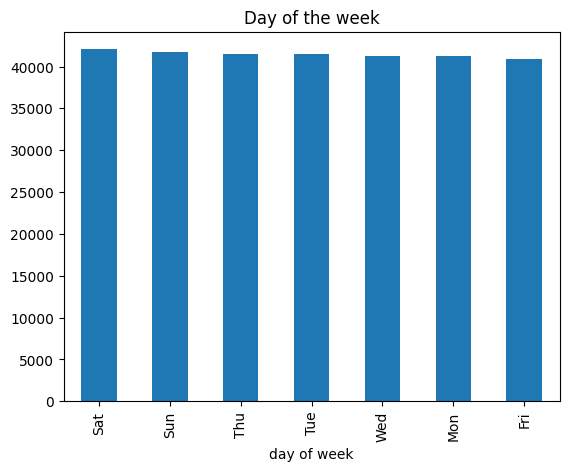

In [11]:
df['day of week'].value_counts().plot(kind='bar', title='Day of the week')

Text(1.2, 180000, '0 : normal day\n1 : public holiday\n2 : summer/winter holiday')

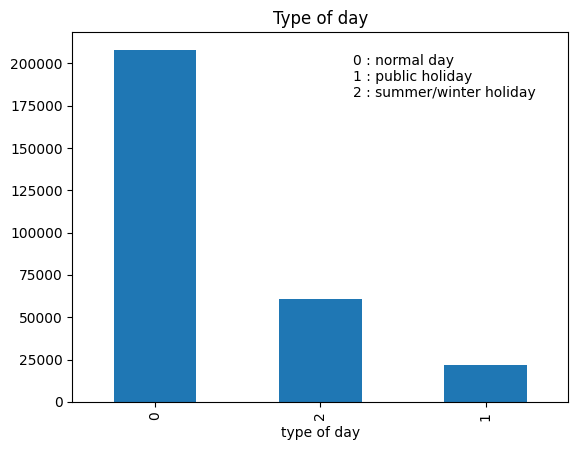

In [12]:
df['type of day'].value_counts().plot(kind='bar', title='Type of day').text(x=1.2, y=180000, s='0 : normal day\n1 : public holiday\n2 : summer/winter holiday')

<Axes: title={'center': 'Season'}, xlabel='season'>

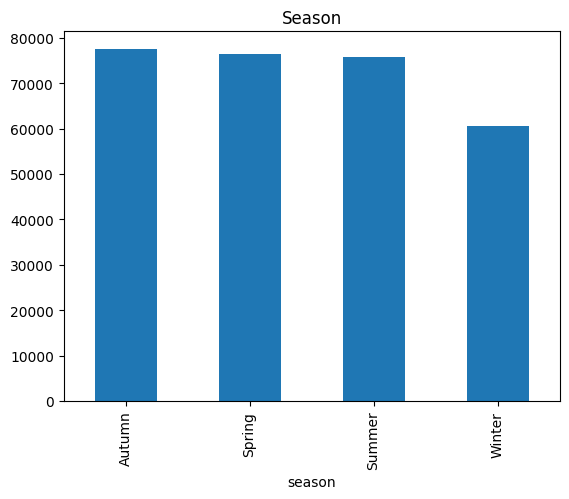

In [13]:
df['season'].value_counts().plot(kind='bar', title='Season')

<Axes: title={'center': 'Daytime'}, xlabel='daytime'>

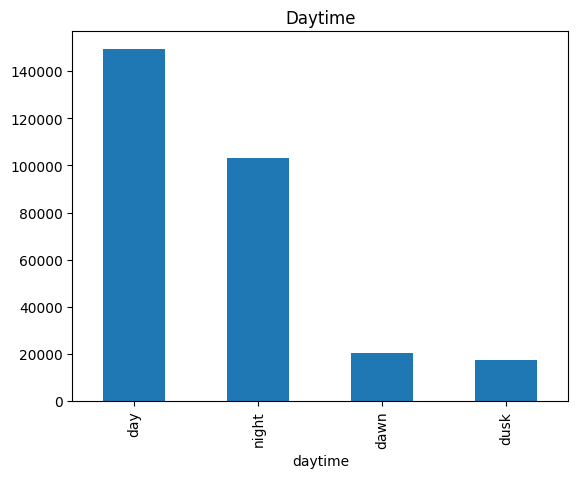

In [14]:
df['daytime'].value_counts().plot(kind='bar', title='Daytime')

<Axes: title={'center': 'Rain intensity'}, ylabel='Frequency'>

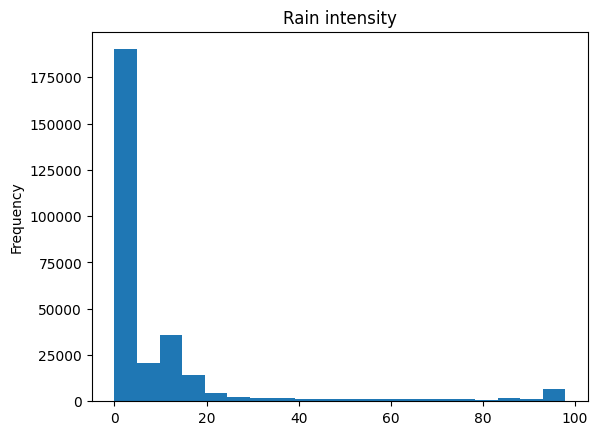

In [15]:
df['rain_intensity'].plot(kind='hist', title='Rain intensity', bins=20)

Text(5, 160000, '0 : no rain\n0.5 : drizzle\n1 : light rain\n2 : moderate rain\n3 : continues rain,\n4 : light snow\n5 : intensive snow')

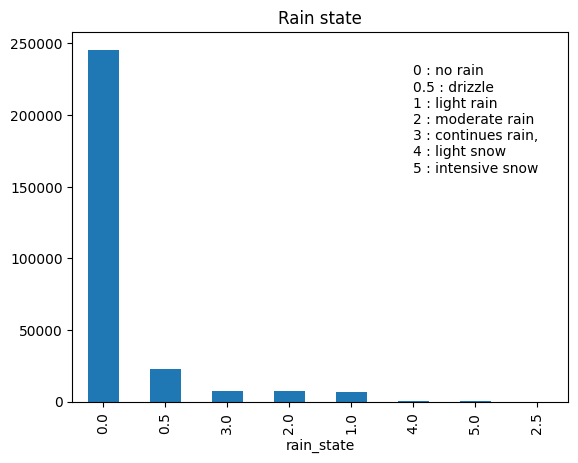

In [16]:
df['rain_state'].value_counts().plot(kind='bar', title='Rain state').text(x=5, y=160000, 
s='0 : no rain\n0.5 : drizzle\n1 : light rain\n2 : moderate rain\n3 : continues rain,\n4 : light snow\n5 : intensive snow')

Text(2.7, 140000, '0 : dry\n1 : moist\n2 : wet\n3 : slippery')

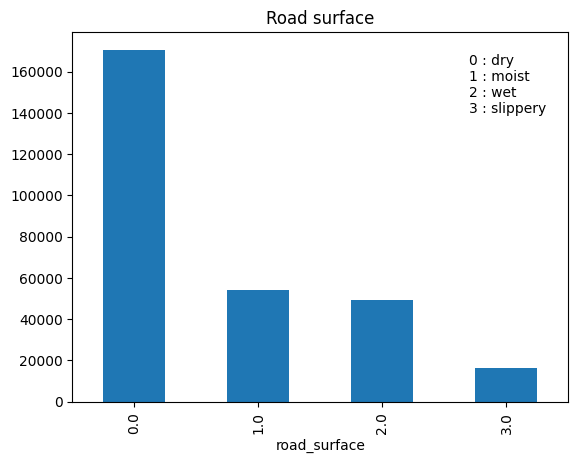

In [17]:
df['road_surface'].value_counts().plot(kind='bar', title='Road surface').text(x=2.7, y=140000, s='0 : dry\n1 : moist\n2 : wet\n3 : slippery')

<Axes: title={'center': 'Temperature in Celcius'}, ylabel='Frequency'>

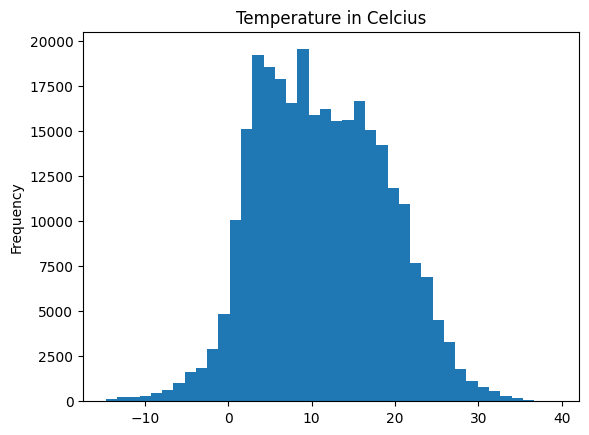

In [18]:
df['temperature'].plot(kind='hist', title='Temperature in Celcius', bins=40)

<Axes: title={'center': 'Visibility'}, xlabel='visibility'>

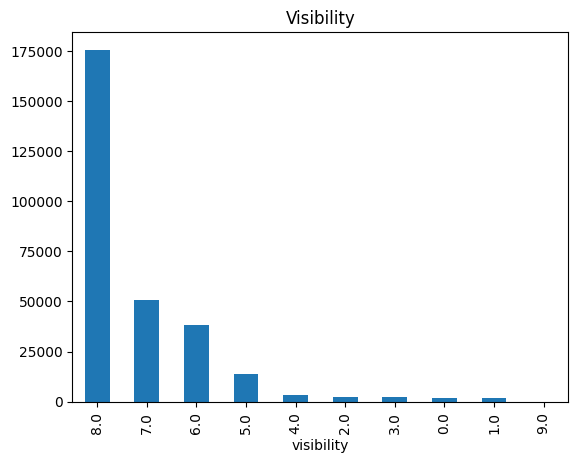

In [19]:
df['visibility'].value_counts().plot(kind='bar', title='Visibility')

<Axes: title={'center': 'Average speed'}, ylabel='Frequency'>

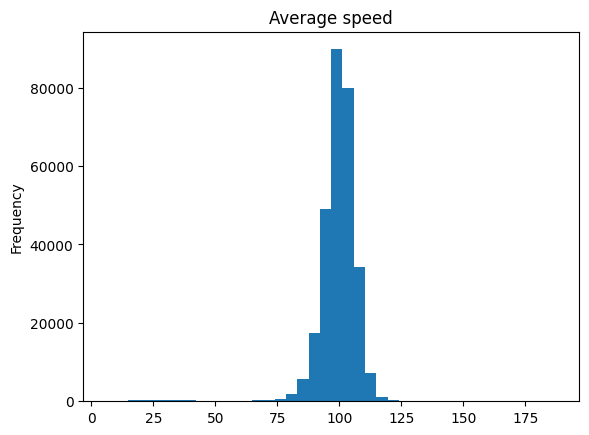

In [20]:
df['avg_speed'].plot(kind='hist', title='Average speed', bins=40)

<Axes: title={'center': 'Average free flow speed'}, ylabel='Frequency'>

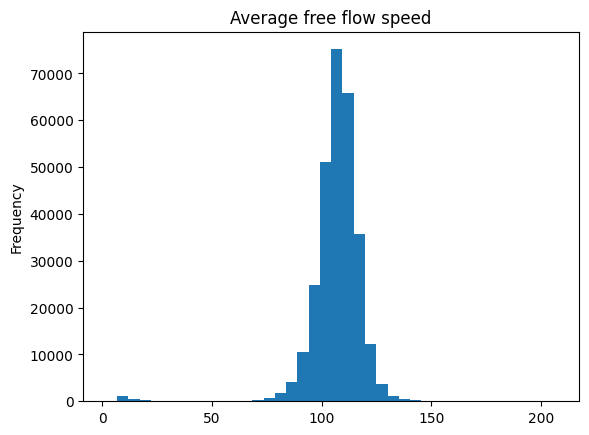

In [21]:
df['avg_FFS'].plot(kind='hist', title='Average free flow speed', bins=40)

<Axes: title={'center': 'Volume'}, ylabel='Frequency'>

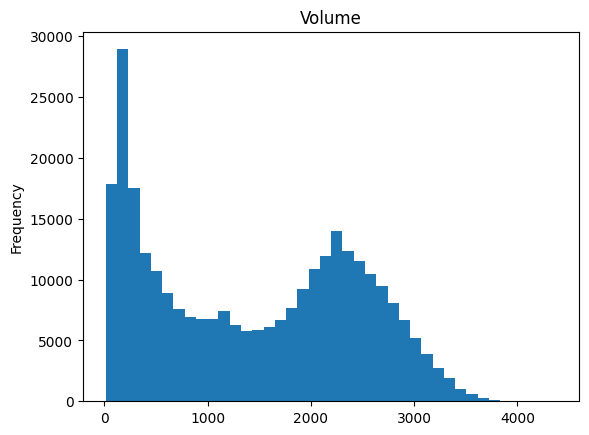

In [22]:
df['volume'].plot(kind='hist', title='Volume', bins=40)

<Axes: title={'center': 'Share of heavy vehicles'}, ylabel='Frequency'>

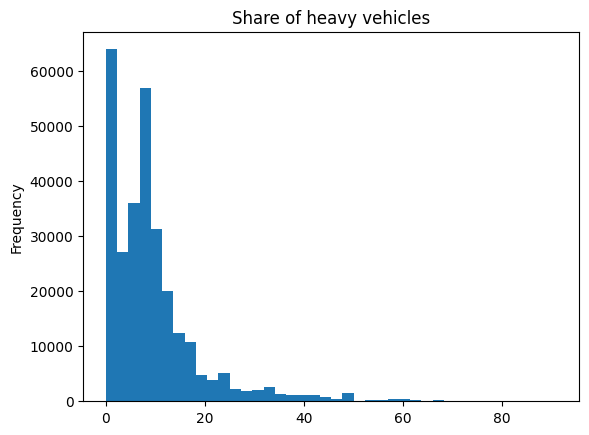

In [23]:
df['share_hv'].plot(kind='hist', title='Share of heavy vehicles', bins=40)

<Axes: title={'center': 'Gap front without outliers'}, ylabel='Frequency'>

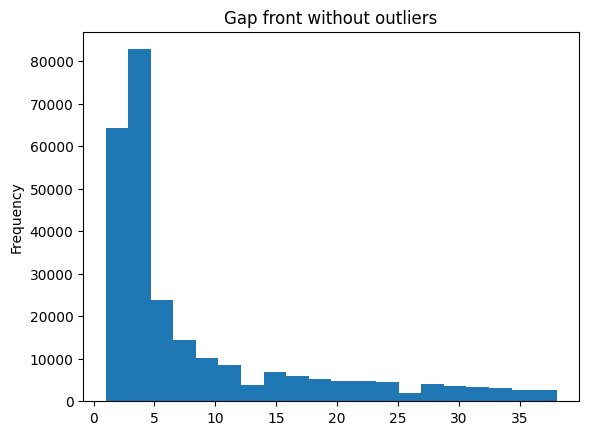

In [24]:
# plot it without outliers using IQR
q1 = df['gap_front'].quantile(0.25)
q3 = df['gap_front'].quantile(0.75)
iqr = q3 - q1
df['gap_front'][df['gap_front'].between(q1 - 1.5*iqr, q3 + 1.5*iqr)].plot(kind='hist', title='Gap front without outliers', bins=20)

In [25]:
df['gap_front'].describe()

count    290351.000000
mean         15.138853
std          97.932662
min           1.000000
25%           3.000000
50%           4.000000
75%          17.000000
max       43508.000000
Name: gap_front, dtype: float64

<Axes: title={'center': 'Gap behind without outliers'}, ylabel='Frequency'>

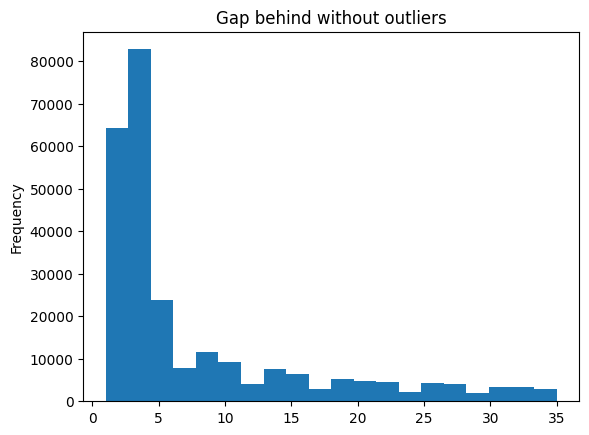

In [26]:
# plot it without outliers using IQR
q1 = df['gap_behind'].quantile(0.25)
q3 = df['gap_behind'].quantile(0.75)
iqr = q3 - q1
df['gap_behind'][df['gap_behind'].between(q1 - 1.5*iqr, q3 + 1.5*iqr)].plot(kind='hist', title='Gap behind without outliers', bins=20)

In [27]:
df['gap_behind'].describe()

count    290351.000000
mean         15.083296
std         101.448267
min           1.000000
25%           3.000000
50%           4.000000
75%          16.000000
max       47213.000000
Name: gap_behind, dtype: float64

<Axes: title={'center': 'Time difference between two consecutive rows'}, ylabel='Frequency'>

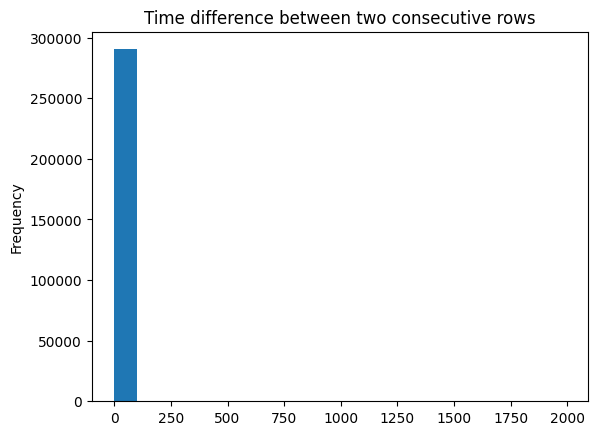

In [28]:
df['time_diff'].plot(kind='hist', title='Time difference between two consecutive rows', bins=20)

In [29]:
df['time_diff'].describe()

count    290350.000000
mean          5.142810
std           7.420313
min           1.000000
25%           5.000000
50%           5.000000
75%           5.000000
max        1991.000000
Name: time_diff, dtype: float64

## Choose features

In [30]:
# assign numeric values to categorical columns
df['day of week'] = df['day of week'].astype('category').cat.codes
df['season'] = df['season'].astype('category').cat.codes
df['daytime'] = df['daytime'].astype('category').cat.codes

In [31]:
# correlation matrix
correlation = df.corr()

In [32]:
# correlation matrix for target variable : volume
correlation['volume'].sort_values(ascending=False)

volume            1.000000
temperature       0.319622
visibility        0.181991
type of day       0.071826
interval          0.052740
day of week       0.011960
time_diff         0.010617
season           -0.009775
rain_state       -0.022106
avg_FFS          -0.034778
rain_intensity   -0.057698
gap_behind       -0.149753
gap_front        -0.155883
avg_speed        -0.189509
road_surface     -0.239392
share_hv         -0.339307
daytime          -0.568334
Name: volume, dtype: float64

In [33]:
# correlation matrix for target variable : avg_speed
correlation['avg_speed'].sort_values(ascending=False)

avg_speed         1.000000
avg_FFS           0.750809
visibility        0.037335
temperature       0.015836
gap_front         0.007061
gap_behind        0.005231
daytime          -0.000550
interval         -0.002797
time_diff        -0.025241
type of day      -0.037650
day of week      -0.039133
season           -0.100847
road_surface     -0.160149
rain_state       -0.170719
rain_intensity   -0.177726
volume           -0.189509
share_hv         -0.253029
Name: avg_speed, dtype: float64

## Implement the Long Short Term Memory (LSTM) method

For the prediction, I implemented a model designed as follow :
- **Model Architecture**: The model architecture consisted of a sequential stack of layers. The first layer was an LSTM layer with 50 units, which takes as input the shape of the training data with dimensions. This layer is responsible for learning the temporal dependencies in the input data.
- **Dropout Layer**: To prevent overfitting, a dropout layer with a dropout rate of 0.2 was added after the LSTM layer. Dropout randomly sets a fraction of input units to zero during training, which helps prevent the model from relying too heavily on specific features or correlations in the data.
- **Output Layer**: A dense layer with a single unit was added as the output layer. This layer produces the predicted traffic volume.

For the prediction of both volume and average speed, two different approaches were explored. Initially, models were trained using a comprehensive set of features including all time-related data and weather conditions. A second set of models was trained using only the features with the best correlation to the respective target variable. For volume prediction, the second model utilized a subset of features with the highest correlation, including 'temperature', 'road_surface', 'visibility', 'daytime', and 'share_hv'. For average speed prediction, a refined model was constructed using a subset of features with the strongest correlation, which included 'season', 'road_surface', 'rain_state', 'rain_intensity', and 'share_hv'.

### Predict volume of traffic

In [34]:
# split the data

X = df.drop(['interval', 
             'volume', 
             'time_diff', 
             'avg_speed',
             'avg_FFS',
             'gap_behind',
             'gap_front',
             ], axis=1)
y = df['volume']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))

X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

In [35]:
if os.path.exists('volume_prediction_all_features.h5'):
    # load the model
    model = tf.keras.models.load_model('volume_prediction_all_features.h5')

else:

    # design LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.build(X_train.shape)

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # train model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                        callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

    # save the model
    model.save('volume_prediction_all_features.h5')

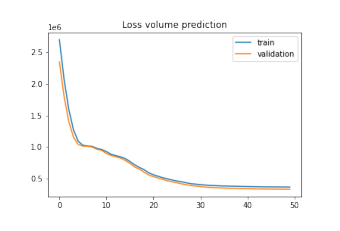

In [36]:
# plot loss
if os.path.exists('img/loss_volume_prediction_all_features.png'):
    img = plt.imread('img/loss_volume_prediction_all_features.png')
    plt.axis('off')
    plt.imshow(img)
else:
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('Loss volume prediction')
    plt.legend()
    plt.savefig('img/loss_volume_prediction_all_features.png')
    plt.show()

In [37]:
# make predictions
yhat = model.predict(X_test)

1815/1815 [==============================] - 4s 2ms/step


In [38]:
# metrics for volume prediction
mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, yhat)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R2 Score: {r2}')

Mean Absolute Error: 444.88873120930486
Mean Squared Error: 335488.1701555341
Root Mean Squared Error: 579.2134064017632
R2 Score: 0.6689880220516893


/home/cytech/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/cytech/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/cytech/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/cytech/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstan

In [39]:
# split the data

X = df[['temperature',
        'road_surface',
        'visibility',
        'daytime',
        'share_hv',
        ]]
y = df['volume']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))

X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

In [40]:
if os.path.exists('volume_prediction_selected_features.h5'):
    # load the model
    model = tf.keras.models.load_model('volume_prediction_selected_features.h5')

else:
    # design LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.build(X_train.shape)

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # train model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                        callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

    # save the model
    model.save('volume_prediction_selected_features.h5')

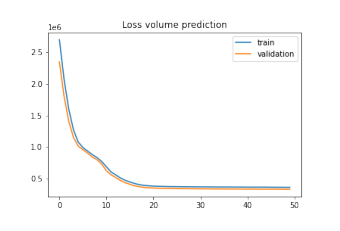

In [41]:
# plot loss
if os.path.exists('img/loss_volume_prediction_selected_features.png'):
    img = plt.imread('img/loss_volume_prediction_selected_features.png')
    plt.axis('off')
    plt.imshow(img)
else:
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('Loss volume prediction')
    plt.legend()
    plt.savefig('img/loss_volume_prediction_selected_features.png')
    plt.show()

In [42]:
# make predictions
yhat = model.predict(X_test)

1815/1815 [==============================] - 3s 1ms/step


In [43]:
# metrics for volume prediction
mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, yhat)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R2 Score: {r2}')

Mean Absolute Error: 430.93592088060865
Mean Squared Error: 332379.64664799726
Root Mean Squared Error: 576.523760696814
R2 Score: 0.6720550706282502


/home/cytech/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/cytech/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/cytech/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/cytech/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstan

### Predict average speed

In [44]:
# split the data

X = df.drop(['interval', 
             'volume', 
             'time_diff', 
             'volume',
             'avg_FFS',
             'gap_behind',
             'gap_front',
             ], axis=1)
y = df['avg_speed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))

X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

In [45]:
if os.path.exists('speed_prediction_all_features.h5'):
    # load the model
    model = tf.keras.models.load_model('speed_prediction_all_features.h5')

else:
    # design LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.build(X_train.shape)

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # train model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                        callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

    # save the model
    model.save('speed_prediction_all_features.h5')

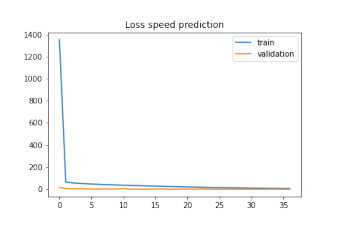

In [46]:
# plot loss
if os.path.exists('img/loss_speed_prediction_all_features.png'):
    img = plt.imread('img/loss_speed_prediction_all_features.png')
    plt.axis('off')
    plt.imshow(img)
else:
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('Loss speed prediction')
    plt.legend()
    plt.savefig('img/loss_speed_prediction_all_features.png')
    plt.show()

In [47]:
# make predictions
yhat = model.predict(X_test)

1815/1815 [==============================] - 3s 1ms/step


In [48]:
# metrics for speed prediction
mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, yhat)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R2 Score: {r2}')

Mean Absolute Error: 0.4660821693986529
Mean Squared Error: 0.5602791979974753
Root Mean Squared Error: 0.748518001117859
R2 Score: 0.9926435155223835


/home/cytech/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/cytech/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/cytech/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/cytech/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstan

In [49]:
# split the data

X = df[['season',
        'road_surface',
        'rain_state',
        'rain_intensity',
        'share_hv',
]]

y = df['avg_speed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))

X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

In [50]:
if os.path.exists('speed_prediction_selected_features.h5'):
    # load the model
    model = tf.keras.models.load_model('speed_prediction_selected_features.h5')

else:
    # design LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.build(X_train.shape)

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # train model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                        callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

    # save the model
    model.save('speed_prediction_selected_features.h5')

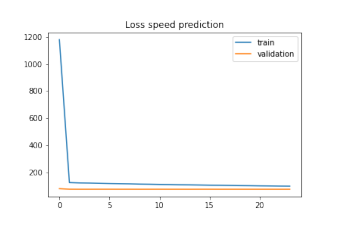

In [51]:
# plot loss
if os.path.exists('img/loss_speed_prediction_selected_features.png'):
    img = plt.imread('img/loss_speed_prediction_selected_features.png')
    plt.axis('off')
    plt.imshow(img)
else:
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('Loss speed prediction')
    plt.legend()
    plt.savefig('img/loss_speed_prediction_selected_features.png')
    plt.show()

In [52]:
# make predictions
yhat = model.predict(X_test)

1815/1815 [==============================] - 3s 1ms/step


In [53]:
# metrics for speed prediction
mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, yhat)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R2 Score: {r2}')

Mean Absolute Error: 5.236037220920162
Mean Squared Error: 76.28569915912355
Root Mean Squared Error: 8.734168486989677
R2 Score: -0.0016337635486156632


/home/cytech/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/cytech/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/cytech/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/cytech/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstan

In conclusion, for traffic volume prediction, we achieved moderate performance, with a slight improvement observed when using correlated variables. Conversely, for average speed prediction, our models demonstrated excellent results when utilizing all features.

Overall, considering the sequential nature of the dataset, the presence of temporal dependencies, variable-length sequences, and the need to capture complex patterns and trends, LSTM appears to be a suitable method for predicting volume and average speed in the dataset.